## Niwot Species Distribution Models
### Aaron Westmoreland, Michael Catchen, Will Reed(?)
---


## I. Introduction

- What did we do (multilevel species dist models) 
- What data do we have (a lot)
- What questions did we answer (none to very few)
- How did we do/not do it (stan)
- What big words can we look forward to hearing in the next 20 minutes? (Bayesian multilevel models, Hamiltonian Monte Carlo)
- Can we say anything about the world based on this analysis? (kinda)
- Can we predict anything about the world based on this analysis? (fat chance, buster)

### Dependencies

#### Load Libraries

In [1]:
# run devtools::install_github("rmcelreath/rethinking") from rstudio
reqs = c("tidyverse", "Rcpp", "rstan", "mvtnorm", "extraDistr","rethinking", "coda","mvtnorm","devtools","loo","dagitty","GGally","rethinking")
lapply(reqs, require, character.only=T)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Rcpp

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: mvtnorm

Loading required package: extraDistr


Attaching package: ‘extraDi

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

#### Load Helper Functions

In [2]:
source('./src/loading_data.R');
source('./src/simulate_data.R');

## II. The Data

### 2.1 Load Data

In [3]:
presence_absence_data = read.csv('./data.csv')
presence_absence_data$time = presence_absence_data$year - 2016
precis(presence_absence_data)
n_plots =  length(unique(presence_absence_data$plot))

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
X,3.635000e+02,2.097224e+02,4.087500e+01,6.861250e+02,▇▇▇▇▇▇▇▂
Easting,4.515599e+05,1.194306e+03,4.493850e+05,4.536260e+05,▂▁▇▁▇▃▇▂▃▂
Northing,4.433183e+06,8.122657e+02,4.431776e+06,4.434395e+06,▂▇▅▅▇▇▁
PA,3.870523e-01,4.874116e-01,0.000000e+00,1.000000e+00,▇▁▁▁▁▁▁▁▁▅
plot,NaN,NA,NA,NA,
top_sub,3.600000e+01,4.485379e+00,3.100000e+01,4.100000e+01,▇▁▁▁▁▁▁▁▃▃
mid_sub,3.625000e+01,4.478142e+00,3.110000e+01,4.140000e+01,▇▇▁▁▁▁▁▁▁▇▇
middle,2.500000e+00,1.306483e+00,1.000000e+00,4.000000e+00,▇▂▁▂▁▇
year,2.017909e+03,7.930735e-01,2.017000e+03,2.019000e+03,▇▁▁▁▇▁▁▁▁▅


### 2.2 Data Exploration

#### Plot Structure

The are Niwot saddle plots. Here we plot them in 2d space.

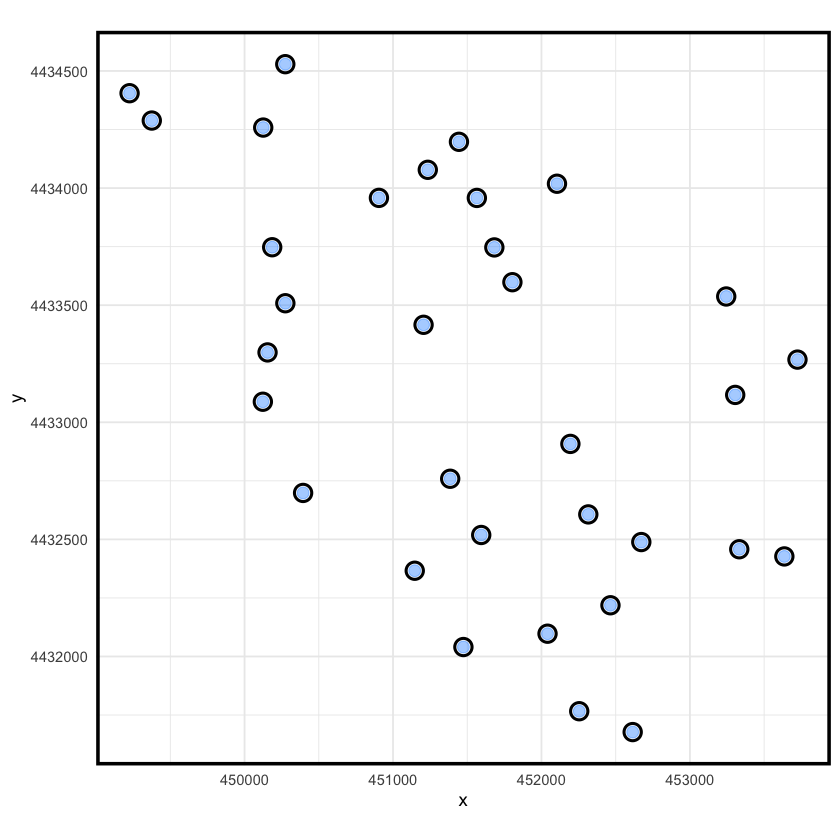

In [4]:
presence_absence_data %>% 
    group_by(plot) %>% 
    summarize(x=mean(Easting), y=mean(Northing)) %>% 
    ggplot(aes(x, y)) + 
        geom_point(size=3,alpha=0.4, color='dodgerblue') +
        geom_point(size=4,stroke=1.3,shape=1) + 
        theme_minimal() + 
        theme(aspect.ratio=1, panel.border=element_rect(fill=NA,size=2))

#### Environmental Variables

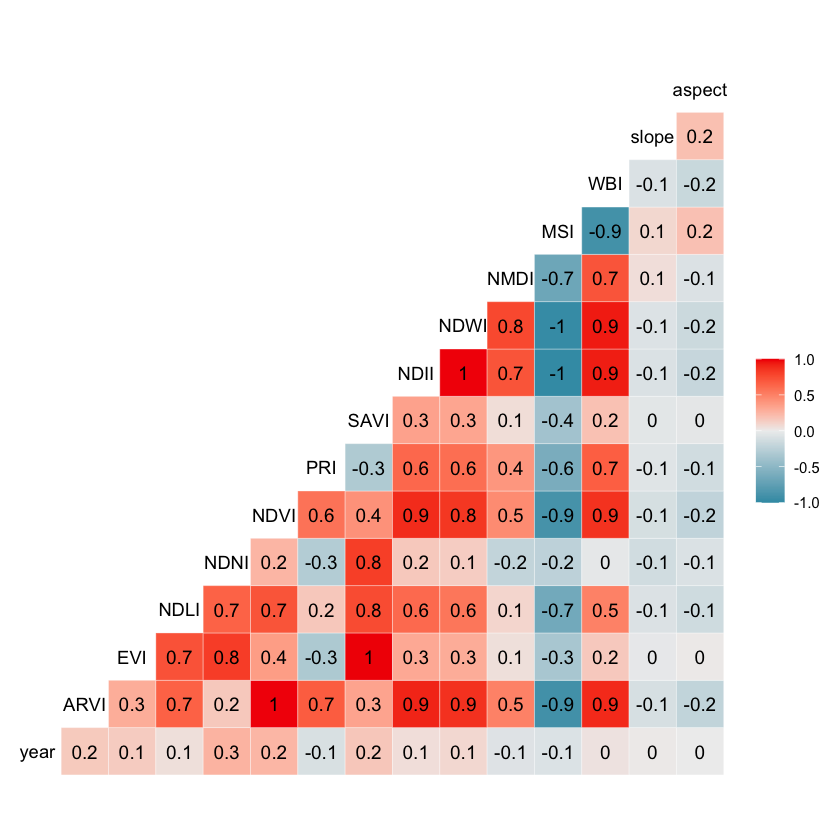

In [6]:
ggcorr(presence_absence_data[,10:ncol(presence_absence_data)-1], label=T)

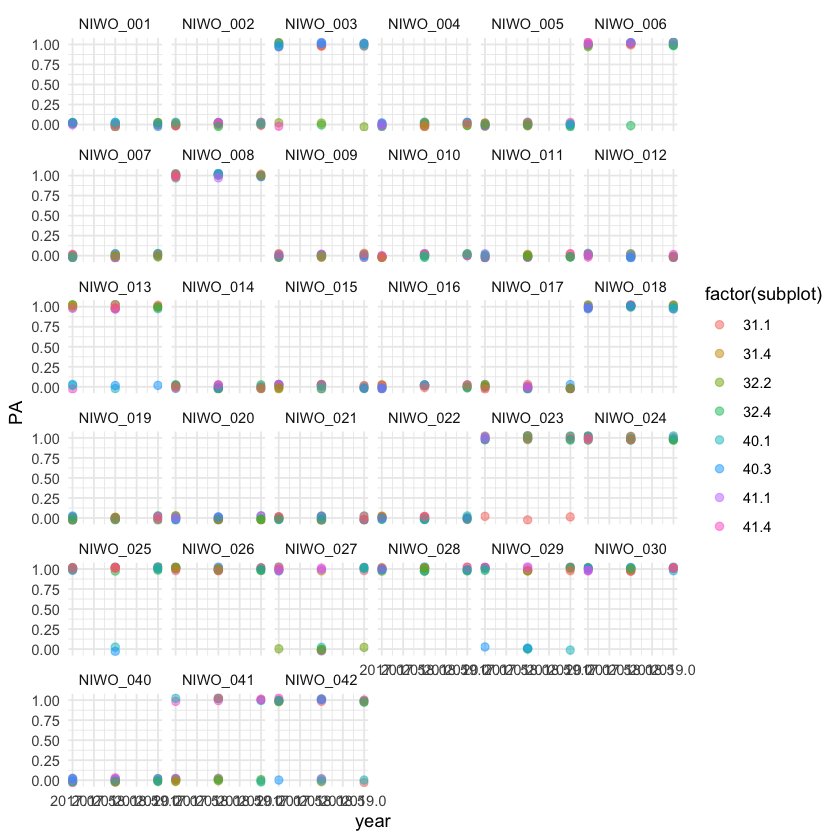

In [6]:
presence_absence_data %>%
    group_by(plot, year) %>%
    ggplot(aes(year, PA, color=factor(subplot))) + 
    geom_jitter(height=0.03,width=0, size=2, alpha=0.5) + 
    facet_wrap(. ~ plot) + 
    theme_minimal() 

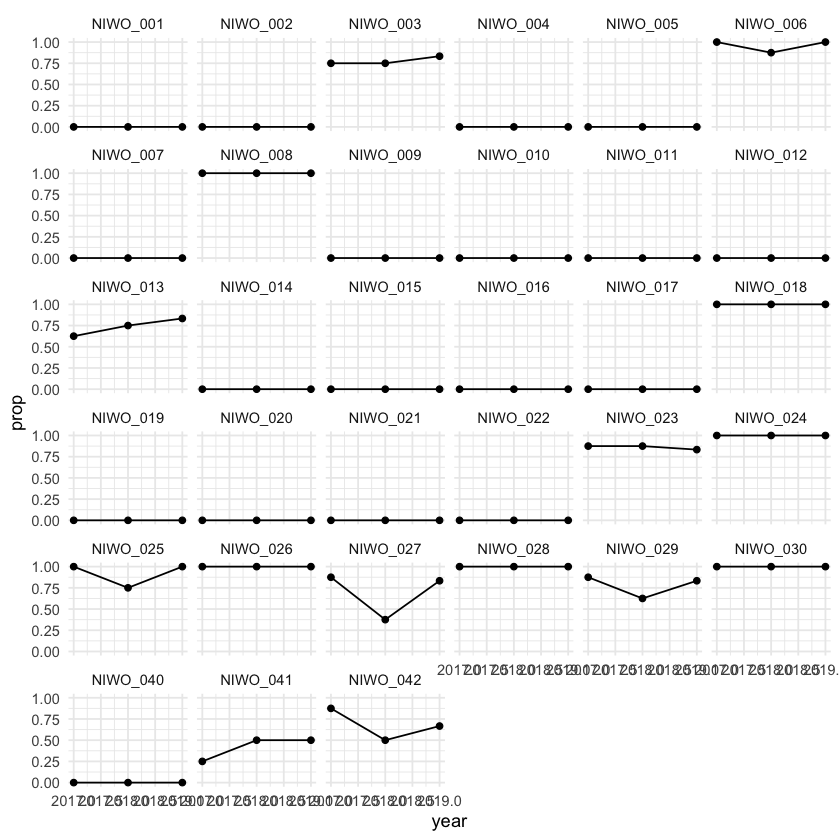

In [4]:
presence_absence_data %>% 
    group_by(plot, year) %>%
    summarize(prop=sum(PA)/length(PA)) %>%
    ggplot(aes(year, prop)) + geom_line() + geom_point() + facet_wrap(. ~ plot) + theme_minimal() + ylim(0,1)

## III. Models

### 3.1 Total Pooling, No Effects

- Total pooling, intercept only, no predictors
- effectively the same as logistic regression of PA with no predictors

$$S_i \sim Bernoulli(p_i) \quad\quad \text{likelihood}$$

$$\text{logit}(p_i) = \alpha \quad\quad \text{link}$$

$$\alpha \sim \text{N}(0,0.5)$$

In [5]:
model3.1 = map2stan(
    alist(
        PA ~ dbinom(1, p),
        logit(p) <- a,
        a ~ dnorm( 0, 5 )
    ),
    data=na.omit(presence_absence_data))
model3.1
model3.1_posterior = data.frame(extract.samples(model3.1))


SAMPLING FOR MODEL '64cbf2b74aaad6c6d6f3e305c7c9a7dd' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000105 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.05 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.41034 seconds (Warm-up)
Chain 1:                0.406849 seconds (Sampling)


Computing WAIC



map2stan model
1000 samples from 1 chain

Sampling durations (seconds):
        warmup sample total
chain:1   0.41   0.41  0.82

Formula:
PA ~ dbinom(1, p)
logit(p) <- a
a ~ dnorm(0, 5)

WAIC (SE): 953 (11.4)
pWAIC: 0.95 

#### 3.1.1 Model Visualization

In [6]:
model3.1_posterior$p = exp(model3.1_posterior$a) / (exp(model3.1_posterior$a) + 1)
model3.1_posterior$sigma = n_plots * model3.1_posterior$p * (1-model3.1_posterior$p) 

In [10]:
distribution_posterior = data.frame(matrix(ncol=3))
colnames(distribution_posterior) = c("x", "pr_x", "sample")
interval = rep(seq(0,33,by=0.1), n_plots)
r = 1

n_samples = length(model3.1_posterior$a)
for (r in 1:5){
    p_hat = rep(model3.1_posterior[r,]$p, length(interval))
    sigma_hat = rep(model3.1_posterior[r,]$sigma, length(interval))
    pr_x = exp((-1*(interval-p_hat)^2)/sigma_hat^2)  
    
    this_df = data.frame(x=interval, pr_x=pr_x, sample=rep(r, length(interval)))
    
    distribution_posterior = rbind(distribution_posterior, this_df)
}
#pr_x = exp((-1*(interval-model3.1_posterior$p)^2)/model3.1_posterior$sigma^2)
distribution_posterior

x,pr_x,sample
<dbl>,<dbl>,<int>
NA,NA,NA
0.0,0.9975059,1
0.1,0.9986115,1
0.2,0.9993960,1
0.3,0.9998588,1
0.4,0.9999993,1
0.5,0.9998175,1
0.6,0.9993135,1
0.7,0.9984879,1


### 3.2 Total Pooling, Indepedent Effects

The dang ol' linear model. 

In [8]:
model3.2 = map2stan(
    # model definition
    alist(
        PA ~ dbinom(1, p),
        logit(p) <- a 
                    + beta_time*time 
                    + beta_MSI*MSI 
                    + beta_NDNI*NDNI 
                    + beta_NDLI*NDLI 
                    + beta_PRI*PRI 
                    + beta_NDVI*NDVI 
                    + beta_NDII*NDII 
                    + beta_NDWI*NDWI,
                    + beta_aspect*aspect,
                    + beta_slope*slope,
        beta_time ~ dnorm(0,5),
        beta_MSI ~ dnorm(0,5),
        beta_NDNI ~ dnorm(0,5),
        beta_NDLI ~ dnorm(0,5),
        beta_PRI ~ dnorm(0,5),
        beta_NDVI ~ dnorm(0,5),
        beta_NDII ~ dnorm(0,5),
        beta_NDWI ~ dnorm(0,5),
        beta_aspect ~ dnorm(0,5)
        beta_slope ~ dnorm(0,5),
        a ~ dnorm( 0, 5 )
    ),
    data=na.omit(presence_absence_data))
post = extract.samples(model3.2)


SAMPLING FOR MODEL '82d00c0e2beccaf001f3565f8431cb01' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000798 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 7.98 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 73.593 seconds (Warm-up)
Chain 1:                39.2958 seconds (Sampling)
Ch

Computing WAIC



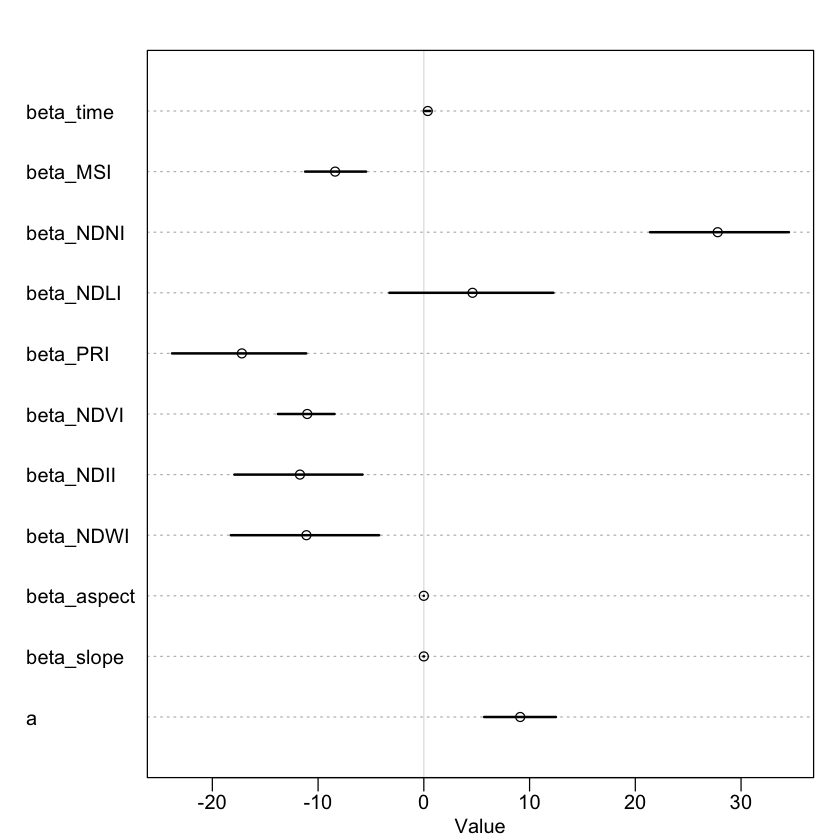

In [9]:
plot(precis(model3.2,depth=2)) # also plot

#### Varying Intercepts

In [9]:
varying_intercepts = map2stan(
    # model definition
    alist(
        PA ~ dbinom(1, p),
        logit(p) <- a 
                    + beta_time*year 
                    + beta_MSI*MSI 
                    + beta_NDNI*NDNI 
                    + beta_NDLI*NDLI 
                    + beta_PRI*PRI 
                    + beta_NDVI*NDVI 
                    + beta_NDII*NDII 
                    + beta_NDWI*NDWI,
        beta_time ~ dnorm(0,5),
        beta_MSI ~ dnorm(0,5),
        beta_NDNI ~ dnorm(0,5),
        beta_NDLI ~ dnorm(0,5),
        beta_PRI ~ dnorm(0,5),
        beta_NDVI ~ dnorm(0,5),
        beta_NDII ~ dnorm(0,5),
        beta_NDWI ~ dnorm(0,5),
        a_mean ~ dnorm(0,1),
        a_var ~ dexp(1),
        a[plot] ~ dnorm( a_mean, a_var )
    ),
    data=na.omit(presence_absence_data))
post = extract.samples(varying_intercepts)


SAMPLING FOR MODEL '02ebbb1089c60e0e55d71327e98afe4e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000555 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 5.55 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 152.92 seconds (Warm-up)
Chain 1:                55.3785 seconds (Sampling)
Ch

Computing WAIC



Here is the 95% interval for the posterior of each parameter 

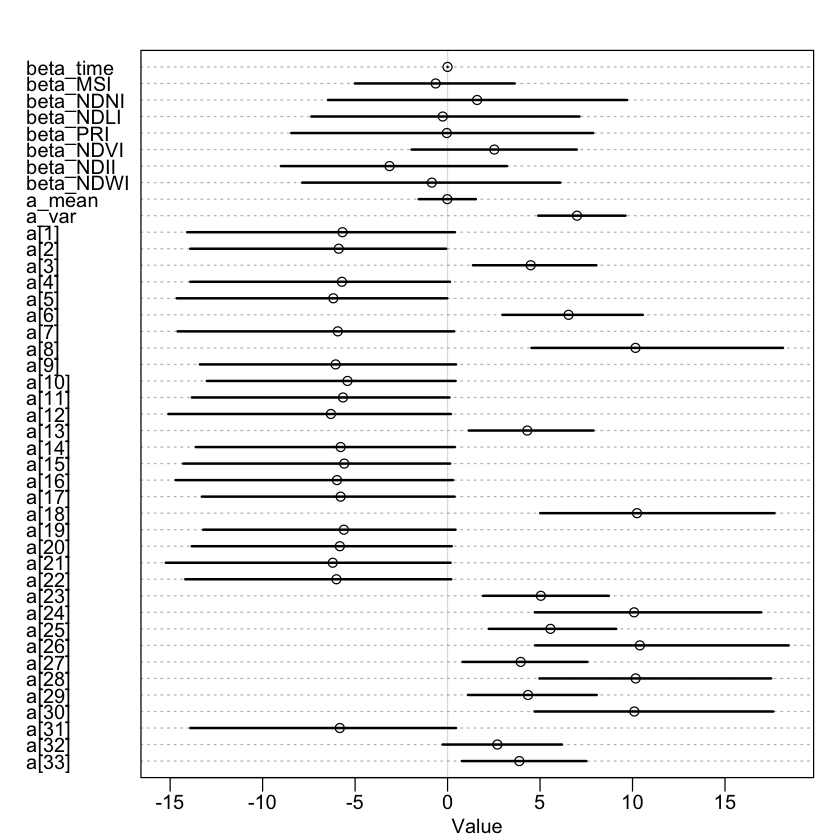

In [15]:
plot(precis(varying_intercepts,width=0.95,depth=2)) # also plot

The intercept for plot $i$, $\alpha_i$, encapsulates the relationship between envirnomental variables for $i$, $\vec{E}_i$. 

$$\alpha_i \propto f(\vec{E}_i)$$

In [1]:
## Plot occurance probs now/ with this model

## what is happening?

- weak effects
- neutral
- what does turnover look like?

### train on 2017 only, and predict 2018.

- "forecasting"

## train on 2017 and 2018, predict 2019
- does more temporal data help?
- obv. we can't say much about if longer time-series can provide this inference
- power analysis on how many timesteps do you need to detect temporal variability?

## how much temporal data would we need to forecast?
- it seems that environmental factors do not have much effect on the distribution of geum in this dataset